In [1]:
import os
import pdb
import torch
import argparse
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.cuda.amp as amp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import metrics
# from arg_parser import get_args_parser
from timeit import default_timer as timer
from timm.models.efficientnet import efficientnet_b0
from Model.ynet import Classification3D

# from MyDataset.dataset import null_collate, padding_size1, padding_size2, cropping_size1, cropping_size2, distance
from MyDataset.dataset import *
from torch.utils.data import DataLoader, SequentialSampler, Dataset
from libs.tools import calculate_acc_pre_rec


is_amp = True 
tensor_key = ['image', 'T_stage']

# parser = argparse.ArgumentParser('Colorectal Cancer Segmentation & T-Stage', parents=[get_args_parser()])
# args = parser.parse_args()



In [2]:

#########################################
#########        helper         #########
#########################################
def time_to_str(t, mode='min'):
    if mode == 'min':
        t  = int(t) / 60
        hr = t // 60
        min = t % 60
        return '%2d hr %02d min' % (hr, min)

    elif mode=='sec':
        t   = int(t)
        min = t // 60
        sec = t % 60
        return '%2d min %02d sec' % (min, sec)

    else:
        raise NotImplementedError

class dotdict(dict):
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)


In [3]:

#########################################
#########         metrics       #########
#########################################
def np_binary_cross_entropy_loss(probability, truth):
	probability = probability.astype(np.float64)
	probability = np.nan_to_num(probability, nan=1, posinf=1, neginf=0)

	p = np.clip(probability,1e-5,1-1e-5)
	y = truth

	loss = -y * np.log(p) - (1-y)*np.log(1-p)
	loss = loss.mean()
	return loss

def get_f1score(probability, truth):
    f1score = []
    threshold = np.linspace(0, 1, 50)
    for t in threshold:
        predict = (probability > t).astype(np.float32)

        tp = ((predict>=0.5) & (truth>=0.5)).sum()
        fp = ((predict>=0.5) & (truth< 0.5)).sum()
        fn = ((predict< 0.5) & (truth>=0.5)).sum()

        r = tp/(tp+fn+1e-3)
        p = tp/(tp+fp+1e-3)
        f1 = 2*r*p/(r+p+1e-3)
        f1score.append(f1)
    f1score=np.array(f1score)
    return f1score, threshold



In [4]:
class CRCDataset(Dataset):
    def __init__(self, df, mode='train', transforms=None):
        df.loc[:, 'i'] = np.arange(len(df))
        self.length = len(df)
        self.df = df
        self.mode = mode
        self.transforms = transforms

    def __str__(self):
        num_patient = len(set(self.df.img_name))
        num_image = len(self.df)

        string = ''
        string += f'\tlen = {len(self)}\n'
        string += f'\tnum_patient = {num_patient}\n'
        string += f'\tnum_image = {num_image}\n'

        count = dict(self.df.T_Stage.value_counts())
        for k in [0,1]:
            string += f'\t\T_Stage{k} = {count[k]:5d} ({count[k]/len(self.df):0.3f})\n'
        return string

    def __len__(self):
        return self.length

    def read_data(self, dd, mode):
        # pdb.set_trace()
        if mode == 'train':
            image_path = f'{image_tr_dir}/{dd.img_name}.nii.gz'
            label_path = f'{mask_tr_dir}/{dd.img_name}.nii.gz'
            # print('Train: ', dd.img_name)

        if mode == 'test':
            image_path = f'{image_ts_dir}/{dd.img_name}.nii.gz'
            label_path = f'{mask_ts_dir}/{dd.img_name}.nii.gz'


        image, label = sitk.ReadImage(image_path), sitk.ReadImage(label_path)

        # pdb.set_trace()


        assert image.GetSize() == label.GetSize()
        
        assert round(image.GetSpacing()[0], 3) == round(label.GetSpacing()[0], 3)
        assert round(image.GetSpacing()[1], 3) == round(label.GetSpacing()[1], 3)
        assert round(image.GetSpacing()[2], 3) == round(label.GetSpacing()[2], 3)

        assert image.GetOrigin() == label.GetOrigin()

        image.SetDirection([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0])
        label.SetDirection([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0])
        assert image.GetDirection() == label.GetDirection()

        # info_dict['Spacing']    = round(image.GetSpacing()[0], 4), round(image.GetSpacing()[1], 4), round(image.GetSpacing()[2], 4)
        info_dict['Spacing']    = target_spacing

        info_dict['Size']       = image.GetSize()
        info_dict['Origin']     = image.GetOrigin()
        info_dict['Direction']  = image.GetDirection()

        rr = {}
        
        rr['Spacing']   = info_dict['Spacing']

        rr['Size']      = info_dict['Size'] 
        rr['Origin']    = info_dict['Origin'] 
        rr['Direction'] = info_dict['Direction']

        # image, label = sitk.GetArrayFromImage(image), sitk.GetArrayFromImage(label)

        return image, label, rr
    
    def ResampleXYZAxis(self, imImage, space=(1., 1., 1.), interp=sitk.sitkLinear):
        identity1 = sitk.Transform(3, sitk.sitkIdentity)
        sp1 = imImage.GetSpacing()
        sz1 = imImage.GetSize()

        sz2 = (int(round(sz1[0]*sp1[0]*1.0/space[0])), int(round(sz1[1]*sp1[1]*1.0/space[1])), int(round(sz1[2]*sp1[2]*1.0/space[2])))

        imRefImage = sitk.Image(sz2, imImage.GetPixelIDValue())
        imRefImage.SetSpacing(space)
        imRefImage.SetOrigin(imImage.GetOrigin())
        imRefImage.SetDirection(imImage.GetDirection())

        imOutImage = sitk.Resample(imImage, imRefImage, identity1, interp)

        return imOutImage

    def ResampleLabelToRef(self, imLabel, imRef, interp=sitk.sitkLinear):
        identity1 = sitk.Transform(3, sitk.sitkIdentity)

        imRefImage = sitk.Image(imRef.GetSize(), imLabel.GetPixelIDValue())
        imRefImage.SetSpacing(imRef.GetSpacing())
        imRefImage.SetOrigin(imRef.GetOrigin())
        imRefImage.SetDirection(imRef.GetDirection())
            
        npLabel = sitk.GetArrayFromImage(imLabel)
        labels = np.unique(npLabel)
        resampled_nplabel_list = []
        for idx in labels:
            tmp_label = (npLabel == idx).astype(np.uint8)
            tmp_imLabel = sitk.GetImageFromArray(tmp_label)
            tmp_imLabel.CopyInformation(imLabel)
            tmp_resampled_Label = sitk.Resample(tmp_imLabel, imRefImage, identity1, interp)
            resampled_nplabel_list.append(sitk.GetArrayFromImage(tmp_resampled_Label))
        
        one_hot_resampled_label = np.stack(resampled_nplabel_list, axis=0)
        resampled_label = np.argmax(one_hot_resampled_label, axis=0)
        outLabel = sitk.GetImageFromArray(resampled_label.astype(np.uint8))
        outLabel.CopyInformation(imRef)

        return outLabel

    def ResampleCRCMRImage(self, imImage, imLabel, target_spacing):
        
        assert imImage.GetSpacing() == imLabel.GetSpacing()
        assert imImage.GetSize() == imLabel.GetSize()

        # pdb.set_trace()

        spacing = imImage.GetSpacing()
        origin = imImage.GetOrigin()


        npimg = sitk.GetArrayFromImage(imImage)
        nplab = sitk.GetArrayFromImage(imLabel)
        z, y, x = npimg.shape

        
        re_img_xy = self.ResampleXYZAxis(imImage, space=(target_spacing[0], target_spacing[1], spacing[2]), interp=sitk.sitkBSpline)
        re_lab_xy = self.ResampleLabelToRef(imLabel, re_img_xy, interp=sitk.sitkNearestNeighbor)

        re_img_xyz = self.ResampleXYZAxis(re_img_xy, space=(target_spacing[0], target_spacing[1], target_spacing[2]), interp=sitk.sitkNearestNeighbor)
        re_lab_xyz = self.ResampleLabelToRef(re_lab_xy, re_img_xyz, interp=sitk.sitkNearestNeighbor)

        return re_img_xyz, re_lab_xyz
    
    def padding_or_cropping(self, image, label, padding_size, cropping_size):

        # padding_size = [128, 128, 128]
        # cropping_size = [128, 128, 128]
        # pdb.set_trace()

        assert image.shape == label.shape
        z, y, x = image.shape
        img, lab = image, label

        ##################### padding ######################
        # pad if the image size is smaller than trainig size
        if z < padding_size[0]:
            if z % 2 == 0:
                # diff = (training_size[0]+2 - z) // 2
                diff = (padding_size[0] - z) // 2
                img = np.pad(img, ((diff, diff), (0,0), (0,0)))
                lab = np.pad(lab, ((diff, diff), (0,0), (0,0)))

            else:
                diff = (padding_size[0] - z) // 2
                img = np.pad(img, ((diff, diff+1), (0,0), (0,0)))
                lab = np.pad(lab, ((diff, diff+1), (0,0), (0,0)))
                
        if y < padding_size[1]:
            if y % 2 == 0:
                diff = (padding_size[1] - y) // 2
                img = np.pad(img, ((0,0), (diff, diff), (0,0)))
                lab = np.pad(lab, ((0,0), (diff, diff), (0,0)))
            
            else:
                diff = (padding_size[1] - y) // 2
                img = np.pad(img, ((0,0), (diff, diff+1), (0,0)))
                lab = np.pad(lab, ((0,0), (diff, diff+1), (0,0)))
              
        if x < padding_size[2]:
            if x % 2 == 0:
                diff = (padding_size[2] - x) // 2
                img = np.pad(img, ((0,0), (0,0), (diff, diff)))
                lab = np.pad(lab, ((0,0), (0,0), (diff, diff)))
            
            else:
                diff = (padding_size[2] - x) // 2
                img = np.pad(img, ((0,0), (0,0), (diff, diff+1)))
                lab = np.pad(lab, ((0,0), (0,0), (diff, diff+1)))
                
        ##################### cropping ######################
        if z > cropping_size[0]:
            size = cropping_size[0]
            img = img[z//2-size//2 : z//2+size//2, :, :]
            lab = lab[z//2-size//2 : z//2+size//2, :, :]

        if y > cropping_size[1]:
            size = cropping_size[1]
            img = img[:, y//2-size//2 : y//2+size//2, :]
            lab = lab[:, y//2-size//2 : y//2+size//2, :]

        if x > cropping_size[2]:
            size = cropping_size[2]
            img = img[:, :, x//2-size//2 : x//2+size//2]
            lab = lab[:, :, x//2-size//2 : x//2+size//2]

        assert img.shape == lab.shape        
        return img, lab

    def get_bbox_from_mask(self, mask, outside_value=0):
        mask_voxel_coords = np.where(mask != outside_value)
        minzidx = int(np.min(mask_voxel_coords[0]))
        maxzidx = int(np.max(mask_voxel_coords[0])) + 1
        minxidx = int(np.min(mask_voxel_coords[1]))
        maxxidx = int(np.max(mask_voxel_coords[1])) + 1
        minyidx = int(np.min(mask_voxel_coords[2]))
        maxyidx = int(np.max(mask_voxel_coords[2])) + 1
        return [[minzidx, maxzidx], [minxidx, maxxidx], [minyidx, maxyidx]]

    def center_cropping(self, image, label):
        assert image.shape == label.shape

        bbox = self.get_bbox_from_mask(label, 0)
        z, x, y = bbox
        z1, z2 = z[0], z[1]
        x1, x2 = x[0], x[1]
        y1, y2 = y[0], y[1]


        image = image[z1 - distance[0] : z2 + distance[0], x1 - distance[1] : x2 + distance[1], y1 - distance[2] : y2 + distance[2]]
        label = label[z1 - distance[0] : z2 + distance[0], x1 - distance[1] : x2 + distance[1], y1 - distance[2] : y2 + distance[2]]

        assert image.shape == label.shape
        return image, label

    def __getitem__(self, index):
        # dd = self.df.iloc[index]

        dd = copy.deepcopy(self.df.iloc[index])

        # step 1
        image, label, info = self.read_data(dd, self.mode)

        # pdb.set_trace()
        # # step 2 
        # # resample
        #                                 #   ResampleCRCMRImage(self, imImage, imLabel, target_spacing=(1., 1., 1.)):
        # image_sampled, label_sampled = self.ResampleCRCMRImage(imImage=image, imLabel=label, target_spacing=(
        #                                                             round(info['Spacing'][1], 4), 
        #                                                             round(info['Spacing'][1], 4), 
        #                                                             round(info['Spacing'][1], 4)))

        # # pdb.set_trace()
        image, label = sitk.GetArrayFromImage(image), sitk.GetArrayFromImage(label)

        # normalisation
        image = (image - image.mean()) / (image.std() + 1e-8)
        image = image.astype(np.float32)


        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)

        # pdb.set_trace()
        sample = {'image': image, 'label': label}

        if self.transforms is not None:
            sample = self.transforms(sample)
        
        # pdb.set_trace()
        image = sample['image'].squeeze(0)
        label = sample['label'].squeeze(0)
        # # pdb.set_trace()



        # # step 3
        # # padding or cropping ==> [512, 512, 512]
        image_padding_cropping1, label_padding_cropping1 = self.padding_or_cropping(image, label, padding_size1, cropping_size1)

        # # step 4
        # # center cropping ==> [z-5 : z+5, x-20 : x+20, y-20 : y+20]
        image_center_cropping, label_center_cropping = self.center_cropping(image_padding_cropping1, label_padding_cropping1)

        # # step 5
        # # padding or cropping ==> [128, 128, 128]
        image_padding_cropping2, label_padding_cropping2 = self.padding_or_cropping(image_center_cropping, label_center_cropping, padding_size2, cropping_size2)
        # assert image_padding_cropping2.shape == label_padding_cropping2.shape

        # print(dd.img_name, 'Done')

        # step 6
        # normalization

        # max98 = np.percentile(image, 98)
        # image = np.clip(image, 0, max98)
        # image = image / max98

        image, label = image_padding_cropping2, label_padding_cropping2


        
        rr = {}
        rr['index'] = index
        rr['d'] = dd
        rr['patient_id'] = dd.img_name  #
        rr['image'] = torch.from_numpy(image).float()
        rr['label'] = torch.from_numpy(label).long()

        # pdb.set_trace()
        
        rr['image'] = rr['image'].unsqueeze(0)
        rr['label'] = rr['label'].unsqueeze(0)

        # pdb.set_trace()

        rr['image'] = torch.cat([
            rr['image'],
            rr['label'],
            # torch.zeros([1, image_size, image_size]),
        ], 0)

        # pdb.set_trace()

        rr['T_stage'] = torch.FloatTensor([dd.T_Stage])

        return rr

In [5]:

#########################################
##########         model       ##########
#########################################
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406]  #
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225]  #
    # IMAGE_RGB_MEAN = [0.5, 0.5, 0.5] #[0.485, 0.456, 0.406]  #
    # IMAGE_RGB_STD  = [0.5, 0.5, 0.5] #[0.229, 0.224, 0.225]  #

    def __init__(self, ):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1, 3, 1, 1))
        self.register_buffer('std', torch.ones(1, 3, 1, 1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x - self.mean) / self.std
        return x

class EffNetB0(nn.Module):
    def load_pretrain(self, ):
        pass

    def __init__(self, ):

        # self.size = size
        super(EffNetB0, self).__init__()

        self.output_type = ['inference', 'loss']

        self.rgb = RGB()
        self.encoder = efficientnet_b0(pretrained=True)
        #encoder_dim = [64, 256, 512, 1024, 2048]

        # self.cancer = nn.Linear(1408,1)         # b2
        self.cancer = nn.Linear(1280,1)         # b0

    def forward(self, batch):
        # pdb.set_trace()
        x = batch['image']
        # x = x.expand(-1,3,-1,-1)
        x = self.rgb(x) #17, 3, 256, 256
        
        #------
        e = self.encoder
        x = e.forward_features(x)

        # x = self.mlp(x)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x,1,3)
        #------

        feature = x
        cancer = self.cancer(feature)
        cancer = cancer.reshape(-1)

        # if 'inference' in self.output_type:
        cancer = torch.sigmoid(cancer)
        output = torch.nan_to_num(cancer.float()) 
        return output


class YNetCls(nn.Module):

    def load_pretrain(self,):
        pass

    def __init__(self,):
        super(YNetCls, self).__init__()

        self.output_type = ['inference', 'loss']
        self.backbone = Classification3D()


    def forward(self, batch):

        x = batch['image']

        # pdb.set_trace()

        e = self.backbone
        x = e(x)
        # x = F.adaptive_avg_pool3d(x, 1)
        # ---------------
        feature = x.reshape(-1)
        # clsout = self.clsout(feature)
        clsout = feature


        # pdb.set_trace()
        # --------------
        # output = {}
        # if  'loss' in self.output_type:
        #     # # loss = F.binary_cross_entropy_with_logits(clsout, batch['T_stage'])
        #     # loss = nn.BCEWithLogitsLoss(reduction='mean')
        #     # output['bce_loss'] = loss(clsout, batch['T_stage'])

        #     loss1 = nn.BCEWithLogitsLoss(reduction='mean')
        #     # loss2 = nn.L1Loss(reduction='mean')
        #     loss2 = nn.SmoothL1Loss(reduction='mean')
        #     # nn.CrossEntropyLoss()
        #     loss3 = DiceLoss()

        #     # pdb.set_trace()

        #     output['bce_loss'] = loss1(clsout, batch['T_stage'])  
        #     output['l1s_loss'] = loss2(clsout, batch['T_stage'].long())
        #     output['dice_loss'] = loss3(clsout, batch['T_stage'].long())

        # if 'inference' in self.output_type:
        clsout = torch.sigmoid(clsout)
        clsout = torch.nan_to_num(clsout)
        output = clsout

        return output
    


In [6]:
def make_train_test_df_filling_well():
    # train_df = pd.read_csv(f'{args.root_dir}/prepare/0505_3D_train_T.csv')
    # train_df = pd.read_csv(f'{args.root_dir}/prepare/0522_3D_train_T_fw.csv')
    train_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0522_3D_train_T_fw.csv')
    # train_df = pd.read_csv(f'{args.root_dir}/prepare/0522_3D_train_T_fnw.csv')

    train_patient_id = train_df.img_name.unique()
    train_patient_id = sorted(train_patient_id)
    train_id = train_patient_id
    train_df = train_df[train_df.img_name.isin(train_id)].reset_index(drop=True)

    # test_df = pd.read_csv(f'/home/workspace/AMP_mysef_2D_Cls/MyDataset/0327_test_img_mask_T.csv')

    # test 
    # test_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0522_3D_test_T.csv')
    # test_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0522_3D_test_T_fw.csv')
    # test_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0522_3D_test_T_fnw.csv')

    # train
    # test_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0505_3D_train_T.csv')
    # test_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0522_3D_train_T_fw.csv')
    test_df = pd.read_csv(f'/home/workspace/research/AMP_mysef_3D_Cls/prepare/0522_3D_train_T_fnw.csv')


    test_patient_id = test_df.img_name.unique()
    test_patient_id = sorted(test_patient_id)
    test_id = test_patient_id
    test_df = test_df[test_df.img_name.isin(test_id)].reset_index(drop=True)

    return train_df, test_df

In [7]:
#######################################################################

# fold = 0
root_dir = '/home/workspace/research/AMP_mysef_3D_Cls'
out_dir  = root_dir + '/res/3D'
fold_dir = out_dir  + f'/fold-all'
initial_checkpoint =\
    '/home/workspace/research/AMP_mysef_3D_Cls/result_0526-3D-fnw-mask-Bspline3/res-0526-3D-fnw-mask-Bspline3-experiment0/0.5-0.5-0-0/YNetCls_3D/128/fold-all/checkpoint/298_YNetCls_3D.pth'
    # '/home/workspace/research/AMP_mysef_3D_Cls/result_0526-3D-fw-mask-Bspline3/res-0526-3D-fw-mask-Bspline3-experiment0/0.5-0.5-0-0/YNetCls_3D/128/fold-all/checkpoint/298_YNetCls_3D.pth'
    # '/home/workspace/research/AMP_mysef_3D_Cls/result_0525-3D-265-mask-Bspline3/res-0525-3D-265-mask-Bspline3-experiment0/0.5-0.5-0-0/YNetCls_3D/128/fold-all/checkpoint/297_YNetCls_3D.pth'
 
    # '/home/workspace/research/AMP_mysef_3D_Cls/result_0526-3D-fnw-mask-Bspline3/res-0526-3D-fnw-mask-Bspline3-experiment0/0.5-0.5-0-0/YNetCls_3D/128/fold-all/128-fold-all-swa.pth'
    # '/home/workspace/research/AMP_mysef_3D_Cls/result_0525-3D-265-mask-Bspline3/res-0525-3D-265-mask-Bspline3-experiment0/0.5-0.5-0-0/YNetCls_3D/128/fold-all/128-fold-all-swa.pth'
    # '/home/workspace/research/AMP_mysef_3D_Cls/result_0526-3D-fw-mask-Bspline3/res-0526-3D-fw-mask-Bspline3-experiment0/0.5-0.5-0-0/YNetCls_3D/128/fold-all/128-fold-all-swa.pth'
    

os.makedirs(fold_dir, exist_ok=True)

def run_valid():
    global fold_dir

    # log = Logger()
    log = open(fold_dir+'/log_submit.txt',mode='a')

    train_df, test_df = make_train_test_df_filling_well()
    valid_dataset = CRCDataset(test_df, 'train')
    # valid_dataset = CRCDataset(test_df, 'test')

    valid_loader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size  = 8,
        drop_last   = False,
        num_workers = 8,
        pin_memory  = False,
        collate_fn = null_collate,
    )
    log.write(f'valid_dataset : \n{valid_dataset}\n')

    #-----
    net = YNetCls().cuda()
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    state_dict = f['state_dict']
    net.load_state_dict(state_dict, strict=True)  # True

    #-----

    valid_num = 0
    valid = dotdict(
        cancer = dotdict(
            truth=[],
            predict=[],
        ),
        
    )

    net = net.eval()
    start_timer = timer()
    for t, batch in enumerate(valid_loader):

        batch_size = len(batch['index'])
        for k in tensor_key: batch[k] = batch[k].cuda()

        net.output_type = ['loss', 'inference']
        with torch.no_grad():
            with amp.autocast(enabled = is_amp):
                output = net(batch)#data_parallel(net, batch) #
                #loss0  = output['vindr_abnormality_loss'].mean()

        valid_num += batch_size
        # pdb.set_trace()
        valid.cancer.truth.append(batch['T_stage'].data.cpu().numpy())
        valid.cancer.predict.append(output.data.cpu().numpy())
        #show_result(batch, output, wait=0)

        #---
        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),time_to_str(timer() - start_timer,'sec')),end='',flush=True)
        #if valid_num==200*4: break

    assert(valid_num == len(valid_loader.dataset))
    cancer_t   = np.concatenate(valid.cancer.truth)
    cancer_p   = np.concatenate(valid.cancer.predict)

    test_df.loc[:,'cancer_p'] = cancer_p
    
    # # valid
    # if 1:
    #     os.makedirs(fold_dir + f'/valid', exist_ok=True)
    #     valid_loader.dataset.df.to_csv(f'{fold_dir}/valid/valid_df.csv',index=False)
    #     np.save(f'{fold_dir}/valid/cancer_t.npy',cancer_t)
    #     np.save(f'{fold_dir}/valid/cancer_p.npy',cancer_p)
    

    # train
    if 1:
        os.makedirs(fold_dir + f'/train', exist_ok=True)
        valid_loader.dataset.df.to_csv(f'{fold_dir}/train/train_df.csv',index=False)
        np.save(f'{fold_dir}/train/cancer_t.npy',cancer_t)
        np.save(f'{fold_dir}/train/cancer_p.npy',cancer_p)

    #------
    cancer_loss  = np_binary_cross_entropy_loss(cancer_p, cancer_t)

    fpr, tpr, thresholds = metrics.roc_curve(cancer_t, cancer_p)
    Auc = metrics.auc(fpr, tpr)

    f1score, threshold = get_f1score(cancer_p, cancer_t)
    i = f1score.argmax()
    f1score, threshold = f1score[i], threshold[i]
    threshold = 0.5
    # pdb.set_trace()
    specificity = ((cancer_p<threshold) &((cancer_t<=0.5))).sum() / (cancer_t<=0.5).sum()
    sensitivity = ((cancer_p>=threshold)&((cancer_t>=0.5))).sum() / (cancer_t>=0.5).sum()


    #---
    # gb = test_df[['patient_id', 'laterality', 'cancer', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
    gb = test_df
    # pdb.set_trace()
    # f1score_mean, threshold_mean = get_f1score(gb.cancer_p, gb.T_Stage)
    # i = f1score_mean.argmax()
    # f1score_mean, threshold_mean = f1score_mean[i], threshold_mean[i]

    # Auc = metrics.roc_auc_score(gb.cancer_p, gb.T_Stage)

    metric = calculate_acc_pre_rec(cancer_t, cancer_p)

    # Acc            =     accuracy(probability, truth)
    Acc            =     metric[0]

    # Precision      =     precision(probability, truth)
    Precision      =     metric[1]

    # Recall         =     recall(probability, truth)
    Recall         =     metric[2]

    # pdb.set_trace()
    # [ cancer_loss, auc, f1score, threshold, sensitivity, specificity, f1score_mean]
    
    # print(
    #     # [ cancer_loss, auc, f1score, threshold, sensitivity, specificity, f1score_mean]
    #     # [ cancer_loss, auc, f1score, threshold, sensitivity, specificity, f1score_mean]
    # )

    # [0.507149379434926, 0.9018, 0.8269, 0.8276, 0.8571, 0.7917, 0.8566]
    print([
        cancer_loss, 
        round(Auc, 4),
        round(Acc, 4),
        round(Precision, 4),
        round(Recall, 4),
        round(specificity, 4),
        round(f1score, 4)
    ])
        # Auc, 
        # Acc, 
        # Precision, 
        # Recall, 
        # specificity
    # [0.543689310144337, 0.8824, 0.8077, 0.9643, 0.75, 0.6667]
    # return [ loss,        Auc,    Acc, Precision, Recall, Specificity] 

def plot_auc(cancer_p, cancer_t):
    cancer_t = cancer_t.astype(int)
        
    pos, bin = np.histogram(cancer_p[cancer_t == 0], np.linspace(0, 1, 20))
    pos = pos / (cancer_t == 0).sum()
        
    neg, bin = np.histogram(cancer_p[cancer_t == 1], np.linspace(0, 1, 20))
    neg = neg / (cancer_t == 1).sum()
    print(pos)
    print(neg)
    # plt.plot(bin[1:],neg, alpha=1)
    # plt.plot(bin[1:],pos, alpha=1)
    bin = (bin[1:] + bin[:-1]) / 2
    plt.bar(bin, neg, width=0.05, label='neg--T3-4',alpha=0.5)
    plt.bar(bin, pos, width=0.05, label='pos--T1-2',alpha=0.5)
    plt.xlabel('Probability')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()


In [8]:
# def plot_roc(cancer_p, cancer_t):
#     clf = svm.SVC(kernel='linear',probability=True,random_state=random_state)
#     clf.fit(x_train, y_train)
#     f1_score = metrics.f1_score(y_test, clf.predict(x_test))
#     print(f1_score)

#     predict_probs = clf.predict_proba(x_test)
#     y_score = predict_probs[:,1]
#     fpr,tpr,thresholds = metrics.roc_curve(y_test, y_score, pos_label=2)
#     roc_auc = metrics.auc(fpr,tpr)  # 计算auc的值

#     # 绘制roc曲线
#     plt.figure()
#     lw = 2
#     plt.figure(figsize=(10,10))
#     plt.plot(fpr, tpr, color='darkorange',lw=lw,label='LR ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0,1.0])
#     plt.ylim([0.0,1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

# plot_roc

In [9]:
# def plot_matrix(y_true, y_pred, labels_name, title=None, thres=0.5, axis_labels=None):
#     cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)  # 生成混淆矩阵 
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化
#     plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
#     plt.colorbar()  # 绘制图例

#     # 图像标题
#     if title is not None:
#         plt.title(title)
    
#     # 绘制坐标
#     num_local = np.array(range(len(labels_name)))
#     if axis_labels is None:
#         axis_labels = labels_name
#     plt.xticks(num_local, axis_labels, rotation=45)  # 将标签印在x轴坐标上， 并倾斜45度
#     plt.yticks(num_local, axis_labels)  # 将标签印在y轴坐标上
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

#     # 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
#     for i in range(np.shape(cm)[0]):
#         for j in range(np.shape(cm)[1]):
#             if int(cm[i][j] * 100 + 0.5) > 0:
#                 plt.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
#                         ha="center", va="center",
#                         color="white" if cm[i][j] > thres else "black")  # 如果要更改颜色风格，需要同时更改此行
#     # 显示
#     plt.show()


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
 
def plot_cm(labels, predictions):
    
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Model1 -- Rectal filling & Non')
    # plt.title('Model1 -- Rectal filling')
    # plt.title('Model1 -- Non Rectal filling')

    # plt.title('Model2 -- Rectal filling')
    # plt.title('Model3 -- Non Rectal filling')


    plt.ylabel('Actual')
    plt.xlabel('Predict')
 
    
# test_predictions = test_model.predict(test_features, batch_size=16)    
#print(test_predictions)
 
# plot_cm(test_labels,test_predictions)

      133 / 133   1 min 28 sec[0.4113651422161107, 1.0, 0.9549, 0.9155, 1.0, 0.9118, 0.9995]
single image
f1score 0.9994848655002028
threshold 0.6733210637019231
auc 1.0

groupby mean
f1score_mean 0.9994848655002028
threshold_mean 0.5714285714285714
auc_mean 1.0

[0.         0.         0.         0.         0.01470588 0.01470588
 0.16176471 0.38235294 0.30882353 0.10294118 0.01470588 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03076923 0.29230769 0.47692308 0.18461538 0.01538462 0.
 0.        ]


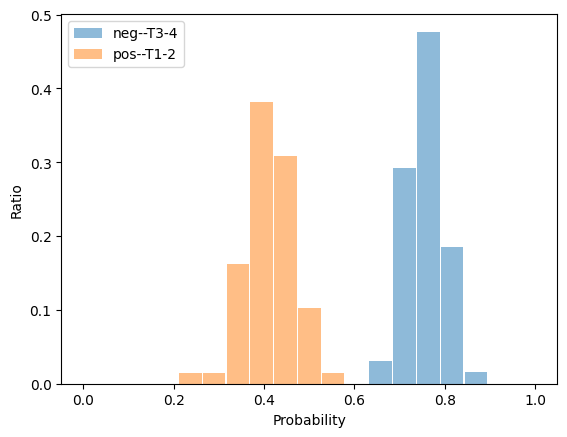

groupby max
f1score_max 0.9994848655002028
threshold_max 0.5714285714285714
auc_mean 1.0



<Figure size 640x480 with 0 Axes>

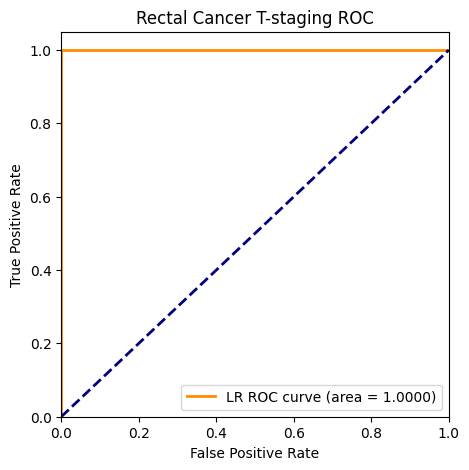

'\ncancer_loss, \n        round(Auc, 4),\n        round(Acc, 4),\n        round(Precision, 4),\n        round(Recall, 4),\n        round(specificity, 4),\n        round(f1score, 4)\n'

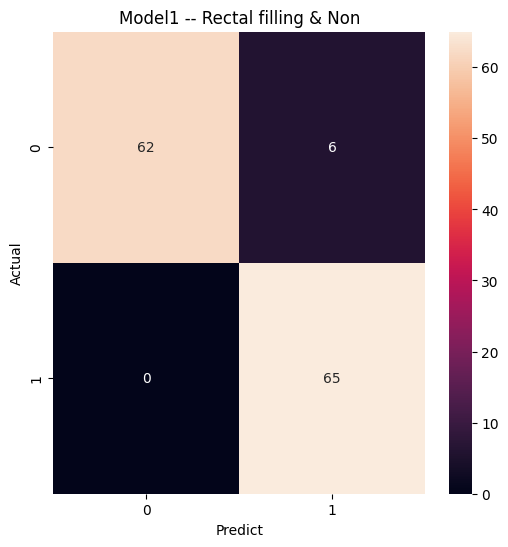

In [11]:

def run_more():
	# valid_df = pd.read_csv(f'{fold_dir}/valid/valid_df.csv')

	# cancer_t  = np.load(f'{fold_dir}/valid/cancer_t.npy', )
	# cancer_p  = np.load(f'{fold_dir}/valid/cancer_p.npy', )
        
	valid_df = pd.read_csv(f'{fold_dir}/train/train_df.csv')

	cancer_t  = np.load(f'{fold_dir}/train/cancer_t.npy', )
	cancer_p  = np.load(f'{fold_dir}/train/cancer_p.npy', )

	valid_df.loc[:,'cancer_p'] = cancer_p
	valid_df.loc[:,'cancer_t'] = valid_df.T_Stage
	# valid_df = valid_df[valid_df.site_id==1].reset_index(drop=True)

	#---

	f1score, threshold = get_f1score(valid_df.cancer_p, valid_df.T_Stage)
	i = f1score.argmax()
	f1score, threshold = f1score[i], threshold[i]

	fpr, tpr, thresholds = metrics.roc_curve(valid_df.T_Stage, valid_df.cancer_p)
	auc = metrics.auc(fpr, tpr)


	print('single image')
	print('f1score', f1score)
	print('threshold', thresholds.mean())
	print('auc', auc)
	print('')

	#---
	# gb = valid_df[['patient_id', 'laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
	gb = valid_df
	f1score_mean, threshold_mean = get_f1score(gb.cancer_p, gb.T_Stage)
	i = f1score_mean.argmax()
	f1score_mean, threshold_mean = f1score_mean[i], threshold_mean[i]

	fpr, tpr, thresholds = metrics.roc_curve(gb.T_Stage, gb.cancer_p)
	auc_mean = metrics.auc(fpr, tpr)


	print('groupby mean')
	print('f1score_mean', f1score_mean)
	print('threshold_mean', threshold_mean)
	print('auc_mean', auc_mean)
	print('')

	plot_auc(gb.cancer_p, gb.T_Stage)

	# ---
	# gb = valid_df[['patient_id', 'laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).max()
	gb = valid_df
	f1score_max, threshold_max = get_f1score(gb.cancer_p, gb.T_Stage)
	i = f1score_max.argmax()
	f1score_max, threshold_max = f1score_max[i], threshold_max[i]

	fpr, tpr, thresholds = metrics.roc_curve(gb.T_Stage, gb.cancer_p)
	auc_max = metrics.auc(fpr, tpr)

	print('groupby max')
	print('f1score_max', f1score_max)
	print('threshold_max', threshold_max)
	print('auc_mean', auc_max)
	print('')


	plt.figure()
	lw = 2
	plt.figure(figsize=(5,5))
        
	plt.plot(fpr * 1.00, tpr * 1.00, color='darkorange',lw=lw,label='LR ROC curve (area = %0.4f)' % (auc * 1.00))
	plt.plot([0, 1.00], [0, 1.00], color='navy', lw=lw, linestyle='--')
	plt.xlim([0.0, 1.00])
	plt.ylim([0.0, 1.05])
        
	# plt.plot(fpr * 100, tpr * 100, color='darkorange',lw=lw,label='LR ROC curve (area = %0.2f)' % (auc * 100))
	# plt.plot([0, 100], [0, 100], color='navy', lw=lw, linestyle='--')
	# plt.xlim([0.0, 100])
	# plt.ylim([0.0, 105])
        
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Rectal Cancer T-staging ROC')
	plt.legend(loc="lower right")
	plt.show()

	# pdb.set_trace()

	plot_cm(gb.T_Stage, gb.cancer_p.round())
	# plot_matrix(gb.T_Stage.argmax(axis=0), gb.cancer_p.argmax(axis=0), [0, 1], title='confusion_matrix_svc', axis_labels=['T1-T2', 'T3-T4'])
	
	# plot_matrix(gb.T_Stage, gb.cancer_p.astype('int'), [0, 1], title='confusion_matrix_svc', axis_labels=['T1-T2', 'T3-T4'])

	# pred = gb.cancer_p

	# pos_data=pred[pred >= 0.5].to_numpy()
	# neg_data=pred[pred <= 0.5].to_numpy()
	# # 绘图
	# # 绘制正样本
	# plt.scatter(pos_data,pos_data,marker='d')
	# # plt.legend('x') 
	# # plt.legend('2')
	# # 绘制负样本
	# plt.scatter(neg_data,neg_data,marker='x')
	# # plt.legend('d') 
	# plt.show()


	return gb.cancer_p, gb.T_Stage, threshold_mean



# main #################################################################
if __name__ == '__main__':
    os.environ['CUDA_VISIBLE_DEVICES']='0'
    run_valid()
    pred, true, threshold_mean = run_more()

'''
cancer_loss, 
        round(Auc, 4),
        round(Acc, 4),
        round(Precision, 4),
        round(Recall, 4),
        round(specificity, 4),
        round(f1score, 4)
'''


In [12]:
pos_data=pred[pred <= 0.5].to_numpy()
neg_data=pred[pred >= 0.5].to_numpy()
pos_data

neg_data


array([0.72802734, 0.75732422, 0.76269531, 0.76953125, 0.75097656,
       0.75292969, 0.77148438, 0.75292969, 0.76660156, 0.77246094,
       0.77587891, 0.76660156, 0.76855469, 0.78857422, 0.76464844,
       0.76757812, 0.69042969, 0.67626953, 0.71240234, 0.67431641,
       0.71337891, 0.68994141, 0.73925781, 0.76074219, 0.72607422,
       0.73291016, 0.71777344, 0.83154297, 0.82910156, 0.80957031,
       0.72167969, 0.74169922, 0.68945312, 0.73193359, 0.71435547,
       0.69628906, 0.81201172, 0.83691406, 0.80322266, 0.77490234,
       0.77783203, 0.75830078, 0.80371094, 0.77197266, 0.80126953,
       0.74951172, 0.51855469, 0.55273438, 0.52197266, 0.52001953,
       0.87158203, 0.5234375 , 0.52539062, 0.68847656, 0.72460938,
       0.71289062, 0.72460938, 0.71435547, 0.73681641, 0.77685547,
       0.83642578, 0.77148438, 0.8125    , 0.73876953, 0.76464844,
       0.77246094, 0.75976562, 0.75976562, 0.82421875, 0.81835938,
       0.77880859])

In [13]:
print(threshold_mean)
threshold_mean

0.5714285714285714


0.5714285714285714

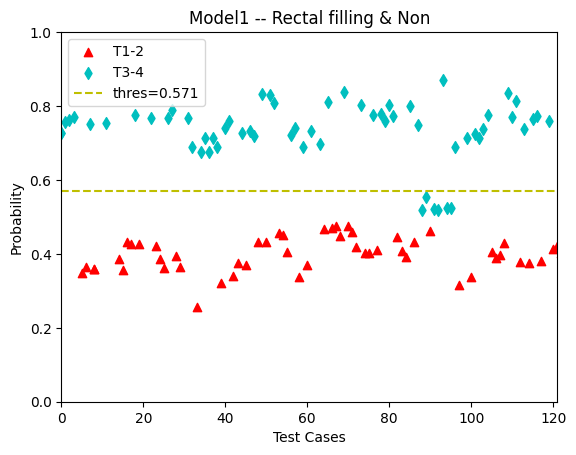

In [14]:
pos_data=pred[pred <= 0.5].to_numpy()
neg_data=pred[pred >= 0.5].to_numpy()

data_dict = {}
for i,j in zip(pred, range(len(pred))):
    data_dict[i] = j

plt.title('Model1 -- Rectal filling & Non')
# plt.title('Model1 -- Rectal filling')
# plt.title('Model1 -- Non Rectal filling')

# plt.title('Model2 -- Rectal filling')
# plt.title('Model3 -- Non Rectal filling')

plt.ylabel("Probability")
plt.xlabel("Test Cases")
x = [i for i in data_dict.keys()]
y = [i for i in data_dict.values()]

x_p = [i for i in x if i >= 0.5]
x_n = [i for i in x if i < 0.5]

                       # [i*2 if i%2==0 else i for i in a_list ]
# plt.scatter(len(x_n), x_n, c='r')

lst = []
for k,v in data_dict.items():
    lst.append([k, v])


for i in lst:
    plt.scatter(i[1], i[0], marker='^'if i[0] < 0.5 else 'd', c='r' if i[0] < 0.5 else 'c')


for i in lst:
    if i[0] < 0.5:
        plt.scatter(i[1], i[0], marker='^'if i[0] < 0.5 else 'd', c='r' if i[0] < 0.5 else 'c', label='T1-2')
        break

for i in lst:
    if i[0] >= 0.5:
        plt.scatter(i[1], i[0], marker='^'if i[0] < 0.5 else 'd', c='r' if i[0] < 0.5 else 'c', label='T3-4')
        break

a = plt.axhline(threshold_mean, c='y', ls='--', label=f'thres={threshold_mean.round(3)}')

plt.ylim([0.0, 1.00])


plt.xlim([0.0, len(x)])


plt.axis([0, len(x), 0, 1])

# plt.legend(a, [thre.mean()])
plt.legend()
plt.show()
